In [1]:
import torch
import torch.nn.functional as F
from torch import nn
import matplotlib.pyplot as plt 
import random 
import math
import numpy as np
import pygad
import pygad.torchga as torchga

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
str_to_inx = {str:inx for inx, str in enumerate(chars, start=1)}
str_to_inx['.'] = 0
inx_to_str = {str:inx for inx, str in str_to_inx.items()}
vocab_size = len(inx_to_str)

# build the dataset
random.shuffle(words)
block_size = 4 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for word in words:
    word = block_size * '.' + word + '.'
    end_inx = block_size
    for start_inx, char in enumerate(word[block_size:]):
        X.append([str_to_inx[ch] for ch in word[start_inx:end_inx]])
        Y.append(str_to_inx[char])
        end_inx += 1


device = torch.device('cpu')

X, Y = torch.tensor(X).to(device), torch.tensor(Y).to(device)

# data set splits 80%, 10%, 10%
train_range = math.ceil(len(X) * 0.8)
dev_range = (len(X) - train_range) // 2

training_set = X[:train_range]
dev_set = X[train_range:train_range+dev_range]
test_set = X[train_range+dev_range:]

y_training_set = Y[:train_range]
y_dev_set = Y[train_range:train_range+dev_range]
y_test_set = Y[train_range+dev_range:]

assert training_set.nelement() + dev_set.nelement() + test_set.nelement() == X.nelement(), "Bad split"

In [3]:

n_embd = 16 # dim of the character embedding vector
n_hidden = 64 # the # of neurons in the hidden layer
g = torch.Generator().manual_seed(2147483647)
    
model = torch.nn.Sequential(
            nn.Embedding(vocab_size, n_embd), nn.Flatten(), 
            nn.Linear(n_embd * block_size, n_hidden, bias=True), nn.LayerNorm(n_hidden), nn.Tanh(),
            nn.Linear(n_hidden, n_hidden, bias=True), nn.LayerNorm(n_hidden), nn.Tanh(),
            nn.Linear(n_hidden, n_hidden, bias=True), nn.LayerNorm(n_hidden), nn.Tanh(),
            nn.Linear(n_hidden, n_hidden, bias=True), nn.LayerNorm(n_hidden), nn.Tanh(),
            nn.Linear(n_hidden, vocab_size, bias=True), nn.LayerNorm(vocab_size),
        )
print(model)
sum(p.nelement() for p in model.parameters())

Sequential(
  (0): Embedding(27, 16)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (4): Tanh()
  (5): Linear(in_features=64, out_features=64, bias=True)
  (6): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (7): Tanh()
  (8): Linear(in_features=64, out_features=64, bias=True)
  (9): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (10): Tanh()
  (11): Linear(in_features=64, out_features=64, bias=True)
  (12): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (13): Tanh()
  (14): Linear(in_features=64, out_features=27, bias=True)
  (15): LayerNorm((27,), eps=1e-05, elementwise_affine=True)
)


19393

In [4]:
torch_ga = torchga.TorchGA(model=model,
                           num_solutions=20)
loss_function = torch.nn.CrossEntropyLoss()

# def fitness_func_factory(model, loss_function, training_set, y_training_set, torch_ga):
def fitness_func(solution, sol_idx):
    global training_set, model, loss_function, y_training_set, torch_ga
    predictions = pygad.torchga.predict(model=model,  
                                        solution=solution,
                                        data=training_set)
    
    loss = loss_function(predictions, y_training_set).detach().numpy()
    # print(f"loss = {loss}")
    solution_fitness = 1.0 / (loss + 1e-6)

    return solution_fitness
    # return fitness_func

def callback_generation(ga_instance):
    print(f"Generation = {ga_instance.generations_completed}")
    print(f"Fitness    = {ga_instance.best_solution()[1]}")

When training PyTorch models using PyGAD, there are multiple solutions and each solution is a vector that holds all the parameters of the model. 

The num_solutions parameter is set to 6 which means the genetic algorithm population will have 6 solutions (i.e. networks). All of these 6 neural networks will have the same architectures as specified by the other parameters.

In [5]:
num_generations = 150 # Number of generations.
num_parents_mating = 10 # Number of solutions to be selected as parents in the mating pool.
initial_population = torch_ga.population_weights # Initial population of network weights.
mutation_percent_genes = 15 
crossover_type = "single_point" 
# gene_space = [{"low": -5, "high": 5} for _ in range(sum(p.nelement() for p in model.parameters())+154)]

# Create an instance of the pygad.GA class
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       initial_population=initial_population,
                       fitness_func=fitness_func,
                       crossover_type=crossover_type,
                     #   gene_space=gene_space,
                       mutation_percent_genes=mutation_percent_genes,
                       on_generation=callback_generation)

# Start the genetic algorithm evolution.
ga_instance.run()



Generation = 1
Fitness    = 0.2792571356871762
Generation = 2
Fitness    = 0.2792571356871762
Generation = 3
Fitness    = 0.2924509436315934
Generation = 4
Fitness    = 0.2924509436315934
Generation = 5
Fitness    = 0.29662621972783076
Generation = 6
Fitness    = 0.3009213841760665
Generation = 7
Fitness    = 0.3039502877239174
Generation = 8
Fitness    = 0.30596661999806263
Generation = 9
Fitness    = 0.3144794736333528
Generation = 10
Fitness    = 0.3144794736333528
Generation = 11
Fitness    = 0.3144794736333528
Generation = 12
Fitness    = 0.3144794736333528
Generation = 13
Fitness    = 0.3144794736333528
Generation = 14
Fitness    = 0.3144794736333528
Generation = 15
Fitness    = 0.3144794736333528
Generation = 16
Fitness    = 0.3144794736333528
Generation = 17
Fitness    = 0.3144794736333528
Generation = 18
Fitness    = 0.3144794736333528
Generation = 19
Fitness    = 0.3144794736333528
Generation = 20
Fitness    = 0.3144794736333528
Generation = 21
Fitness    = 0.3144794736333528

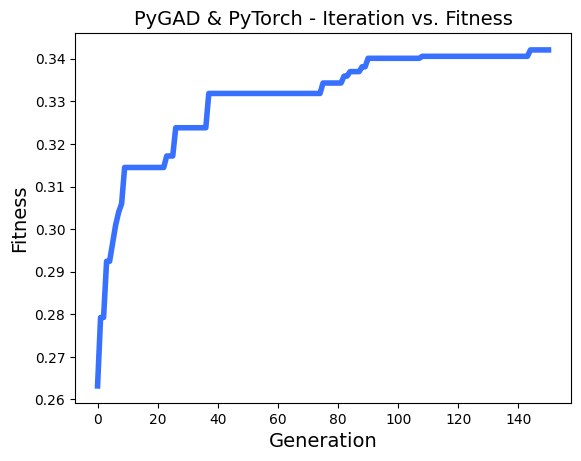

tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(9)
tensor(9)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(9)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(9)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(9)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(9)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(9)
tensor(0)
['careah', 'aai', 'hl', 'ihkigli', 'rthty', 'hnaayane', 'rrhnen', 'apeirhc', 'igeei', 'ne']
Crossentropy :  2.919804


In [9]:
# After the generations complete, some plots are showed that summarize how the outputs/fitness values evolve over generations.
ga_instance.plot_fitness(title="PyGAD & PyTorch - Iteration vs. Fitness", linewidth=4);


g = torch.Generator().manual_seed(2147483647 + 10)
solution = ga_instance.best_solution()[0]

# Fetch the parameters of the best solution.
best_solution_weights = torchga.model_weights_as_dict(model=model, weights_vector=solution)

model.load_state_dict(best_solution_weights)
# model.eval()
# for name, layer in model.named_modules():
#     if isinstance(layer, torch.nn.BatchNorm1d):
#         layer.track_running_stats = False # or layer.requires_grad = True
samples = []
with torch.no_grad():

	for _ in range(10):
		out = '.' * block_size
		while True:
			x = torch.tensor([str_to_inx[x] for x in out[-block_size:]])
			x = x.view(1, -1)
			logits = model(x)
			probs = F.softmax(logits, dim=1)
			print(torch.argmax(probs))        
			# print(probs)
			# print(probs.sum())
			inx = torch.multinomial(probs, num_samples=1, generator=g).item()
			out = out + inx_to_str[inx]
			if inx == 0:
				break
		samples.append(out.replace('.', ''))
	print(samples)


# --------------------------------------------------

# # Returning the details of the best solution.
# solution, solution_fitness, solution_idx = ga_instance.best_solution()
# print(f"Fitness value of the best solution = {solution_fitness}")
# print(f"Index of the best solution : {solution_idx}")

# # Fetch the parameters of the best solution.
# best_solution_weights = torchga.model_weights_as_dict(model=model,
#                                                         weights_vector=solution)
# print(len(best_solution_weights))
# # print(best_solution_weights)

# model.load_state_dict(best_solution_weights)

# for name, layer in model.named_modules():
#     if isinstance(layer, torch.nn.BatchNorm1d):
#         layer.track_running_stats = False # or layer.requires_grad = True

# # model.eval()
predictions = model(test_set)
# print("Predictions : \n", predictions.detach().numpy())

# # Calculate the crossentropy loss of the trained model.
print("Crossentropy : ", loss_function(predictions, y_test_set).detach().numpy())

# # Calculate the classification accuracy for the trained model.
# accuracy = torch.sum(torch.max(predictions, axis=1).indices == y_test_set) / len(y_test_set)
# print("Accuracy : ", accuracy.detach().numpy())

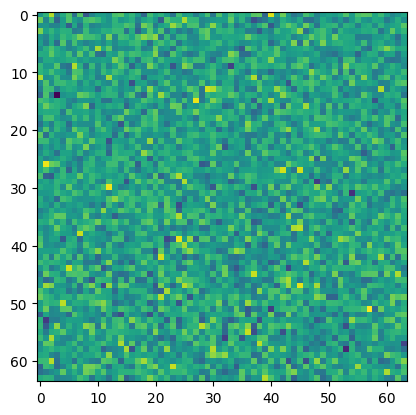

In [7]:
plt.imshow(best_solution_weights['2.weight'])

In [8]:
# sample from the model

@torch.no_grad()
def sample(model, ga_instance):
	model.eval()
	g = torch.Generator().manual_seed(2147483647 + 10)
	solution= ga_instance.best_solution()[0]

	# Fetch the parameters of the best solution.
	best_solution_weights = torchga.model_weights_as_dict(model=model, weights_vector=solution)

	model.load_state_dict(best_solution_weights)
	for _ in range(20):
		out = '.' * block_size
		while True:
			x = torch.tensor([str_to_inx[x] for x in out[-block_size:]])
			x = x.view(1, -1)
			print(x)
			
			probs = model(x)
			print(probs)
			probs = model(x)
			inx = torch.multinomial(probs, num_samples=1, generator=g).item()
			out = out + inx_to_str[inx]
			if inx == 0:
				break
		
		print(out.replace('.', ''))
sample(model, ga_instance)

tensor([[0, 0, 0, 0]])
tensor([[ 0.8230,  1.5385, -2.3929, -0.5256, -0.3749,  0.8663, -2.1877, -0.0366,
          0.1278,  1.3003, -5.0662, -0.9004,  0.6403, -1.0581,  0.5360, -0.9557,
         -2.5687, -5.4982,  0.8433, -0.4433, -0.2079, -2.1676, -1.8617, -0.9960,
         -3.3036,  0.3899, -0.3679]])


RuntimeError: probability tensor contains either `inf`, `nan` or element < 0

In [ ]:
best_solution_weights.keys()